In [1]:
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc


In [2]:
out_dir = "/ix/djishnu/Aaron_F/ES_interact/Results/substrate_attention/checkpoints"
# Load the file
data = np.load('/ix/djishnu/Aaron_F/ES_interact/Results/substrate_attention/checkpoints/out_files/test_predictions.npz')

In [3]:
# It contains two arrays:
predictions = data['predictions']  # Model's predicted probabilities [0-1]
labels = data['labels']            # True labels [0 or 1]

print(f"Shape: {predictions.shape}")  # Should be around (7,354,) - your test set size
print(f"Sample predictions: {predictions[:10]}")
print(f"Sample labels: {labels[:10]}")

Shape: (26966,)
Sample predictions: [0.33004916 0.5372828  0.1311998  0.01466374 0.01593127 0.04553073
 0.00762813 0.42760468 0.03886261 0.01910472]
Sample labels: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


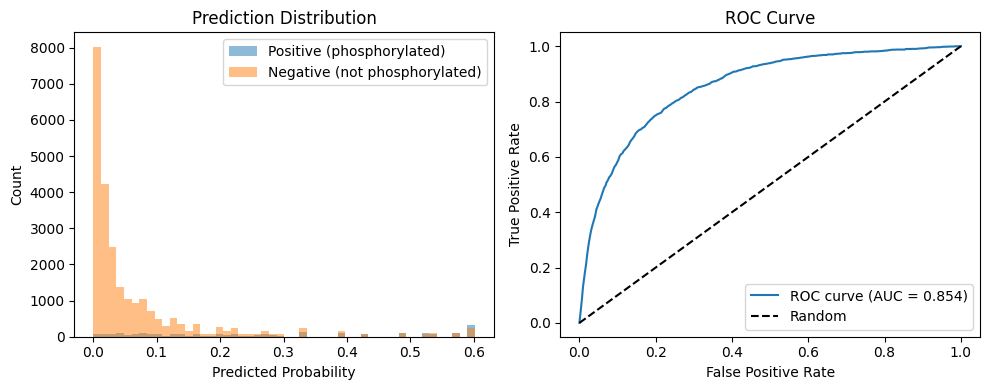

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Histogram of predictions
plt.subplot(1, 2, 1)
plt.hist(predictions[labels == 1], alpha=0.5, bins=50, label='Positive (phosphorylated)')
plt.hist(predictions[labels == 0], alpha=0.5, bins=50, label='Negative (not phosphorylated)')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.legend()
plt.title('Prediction Distribution')

# ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(labels, predictions)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.tight_layout()
plt.savefig(f"{out_dir}/figures/ROC_and_PredictionDistribution_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

In [5]:
# Using 0.5 threshold
pred_binary = (predictions > 0.5).astype(int)

# Find false positives and false negatives
false_positives = np.where((pred_binary == 1) & (labels == 0))[0]
false_negatives = np.where((pred_binary == 0) & (labels == 1))[0]

print(f"False positives: {len(false_positives)}")
print(f"False negatives: {len(false_negatives)}")

# Look at most confident errors
fp_confidence = predictions[false_positives]
fn_confidence = 1 - predictions[false_negatives]

print(f"\nMost confident false positive: {predictions[false_positives[np.argmax(fp_confidence)]]:.4f}")
print(f"Most confident false negative: {predictions[false_negatives[np.argmax(fn_confidence)]]:.4f}")

False positives: 504
False negatives: 1841

Most confident false positive: 0.6016
Most confident false negative: 0.0006


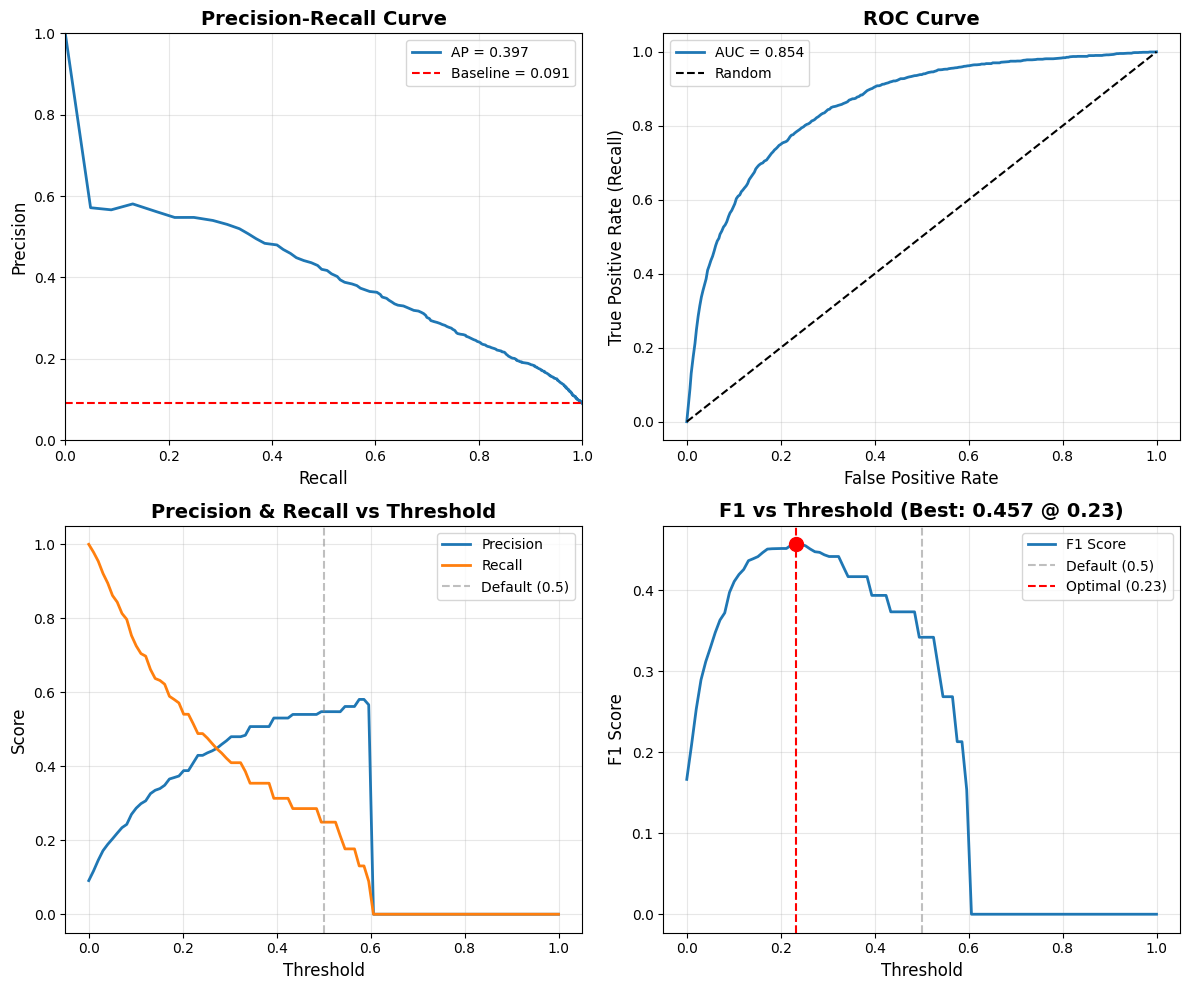


PERFORMANCE SUMMARY
AUC-ROC:              0.8544
Average Precision:    0.3971
Baseline (random):    0.0909

At threshold = 0.5:
  Precision:          0.5476
  Recall:             0.2489
  F1:                 0.3422

At optimal threshold = 0.23:
  Precision:          0.4295
  Recall:             0.4884
  F1:                 0.4570


In [6]:
# Create figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# ============================================================================
# 1. Precision-Recall Curve (most important for imbalanced data!)
# ============================================================================
precision, recall, pr_thresholds = precision_recall_curve(labels, predictions)
avg_precision = average_precision_score(labels, predictions)

axes[0, 0].plot(recall, precision, linewidth=2, label=f'AP = {avg_precision:.3f}')
axes[0, 0].axhline(y=labels.mean(), color='r', linestyle='--', 
                    label=f'Baseline = {labels.mean():.3f}')
axes[0, 0].set_xlabel('Recall', fontsize=12)
axes[0, 0].set_ylabel('Precision', fontsize=12)
axes[0, 0].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlim([0, 1])
axes[0, 0].set_ylim([0, 1])

# ============================================================================
# 2. ROC Curve (for comparison)
# ============================================================================
fpr, tpr, roc_thresholds = roc_curve(labels, predictions)
roc_auc = auc(fpr, tpr)

axes[0, 1].plot(fpr, tpr, linewidth=2, label=f'AUC = {roc_auc:.3f}')
axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 1].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 1].set_ylabel('True Positive Rate (Recall)', fontsize=12)
axes[0, 1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# ============================================================================
# 3. Precision and Recall vs Threshold
# ============================================================================
# Need to compute metrics at various thresholds
thresholds = np.linspace(0, 1, 100)
precisions = []
recalls = []

for thresh in thresholds:
    pred_binary = (predictions >= thresh).astype(int)
    tp = np.sum((pred_binary == 1) & (labels == 1))
    fp = np.sum((pred_binary == 1) & (labels == 0))
    fn = np.sum((pred_binary == 0) & (labels == 1))
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    precisions.append(precision)
    recalls.append(recall)

axes[1, 0].plot(thresholds, precisions, linewidth=2, label='Precision')
axes[1, 0].plot(thresholds, recalls, linewidth=2, label='Recall')
axes[1, 0].axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Default (0.5)')
axes[1, 0].set_xlabel('Threshold', fontsize=12)
axes[1, 0].set_ylabel('Score', fontsize=12)
axes[1, 0].set_title('Precision & Recall vs Threshold', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# ============================================================================
# 4. F1 Score vs Threshold (find optimal threshold)
# ============================================================================
f1_scores = []
for p, r in zip(precisions, recalls):
    if p + r > 0:
        f1_scores.append(2 * p * r / (p + r))
    else:
        f1_scores.append(0)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

axes[1, 1].plot(thresholds, f1_scores, linewidth=2, label='F1 Score')
axes[1, 1].axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Default (0.5)')
axes[1, 1].axvline(x=best_threshold, color='red', linestyle='--', 
                    label=f'Optimal ({best_threshold:.2f})')
axes[1, 1].scatter([best_threshold], [best_f1], color='red', s=100, zorder=5)
axes[1, 1].set_xlabel('Threshold', fontsize=12)
axes[1, 1].set_ylabel('F1 Score', fontsize=12)
axes[1, 1].set_title(f'F1 vs Threshold (Best: {best_f1:.3f} @ {best_threshold:.2f})', 
                      fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{out_dir}/figures/precision_recall_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n{'='*60}")
print("PERFORMANCE SUMMARY")
print(f"{'='*60}")
print(f"AUC-ROC:              {roc_auc:.4f}")
print(f"Average Precision:    {avg_precision:.4f}")
print(f"Baseline (random):    {labels.mean():.4f}")
print(f"\nAt threshold = 0.5:")
pred_binary_05 = (predictions >= 0.5).astype(int)
tp_05 = np.sum((pred_binary_05 == 1) & (labels == 1))
fp_05 = np.sum((pred_binary_05 == 1) & (labels == 0))
fn_05 = np.sum((pred_binary_05 == 0) & (labels == 1))
tn_05 = np.sum((pred_binary_05 == 0) & (labels == 0))
print(f"  Precision:          {tp_05/(tp_05+fp_05):.4f}")
print(f"  Recall:             {tp_05/(tp_05+fn_05):.4f}")
print(f"  F1:                 {2*tp_05/(2*tp_05+fp_05+fn_05):.4f}")
print(f"\nAt optimal threshold = {best_threshold:.2f}:")
pred_binary_opt = (predictions >= best_threshold).astype(int)
tp_opt = np.sum((pred_binary_opt == 1) & (labels == 1))
fp_opt = np.sum((pred_binary_opt == 1) & (labels == 0))
fn_opt = np.sum((pred_binary_opt == 0) & (labels == 1))
print(f"  Precision:          {tp_opt/(tp_opt+fp_opt):.4f}")
print(f"  Recall:             {tp_opt/(tp_opt+fn_opt):.4f}")
print(f"  F1:                 {best_f1:.4f}")
print(f"{'='*60}")